# 1. Import Library

In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.api as sm
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# 2. Data Loading & Splitting

In [3]:
# Load dataset
df = pd.read_csv('car_evaluation.csv')
df.head()

,very high,very high.1,2,2.1,small,low,unaccepted
0,very high,very high,2,2,small,medium,unaccepted
1,very high,very high,2,2,small,high,unaccepted
2,very high,very high,2,2,medium,low,unaccepted
3,very high,very high,2,2,medium,medium,unaccepted
4,very high,very high,2,2,medium,high,unaccepted


In [4]:
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,very high,very high.1,2,2.1,small,low,unaccepted
0,high,low,2,2,medium,medium,unaccepted
1,low,high,2,2,medium,low,unaccepted
2,high,high,3,4,big,low,unaccepted
3,high,medium,2,more,big,medium,accepted
4,medium,high,more,2,medium,medium,unaccepted


In [5]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   very high    1727 non-null   object
 1   very high.1  1727 non-null   object
 2   2            1727 non-null   object
 3   2.1          1727 non-null   object
 4   small        1727 non-null   object
 5   low          1727 non-null   object
 6   unaccepted   1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [6]:
# Size of Dataset
R = df.shape[0]
C = df.shape[1]
print(f"Number of rows: {R}")
print(f"Number of columns: {C}")

Number of rows: 1727
Number of columns: 7


In [7]:
# Get testing data
df_test = df.iloc[:R//5, :]
df_test.head()

,very high,very high.1,2,2.1,small,low,unaccepted
0,high,low,2,2,medium,medium,unaccepted
1,low,high,2,2,medium,low,unaccepted
2,high,high,3,4,big,low,unaccepted
3,high,medium,2,more,big,medium,accepted
4,medium,high,more,2,medium,medium,unaccepted


In [8]:
# Display the shape
print(f"Number of rows: {df_test.shape[0]}")
print(f"Number of columns: {df_test.shape[1]}")

Number of rows: 345
Number of columns: 7


In [9]:
# Get training data
df_train = df.iloc[R//5:, :]
df_train.head()

,very high,very high.1,2,2.1,small,low,unaccepted
345,low,very high,more,2,big,high,unaccepted
346,medium,very high,4,2,small,low,unaccepted
347,medium,very high,3,more,big,high,accepted
348,low,very high,4,more,small,high,accepted
349,low,medium,4,more,medium,low,unaccepted


In [10]:
# Display the shape
print(f"Number of rows: {df_train.shape[0]}")
print(f"Number of columns: {df_train.shape[1]}")

Number of rows: 1382
Number of columns: 7


# 3. EDA & Data Preprocessing

### 3.1 Training Data

In [11]:
# Size of Dataset
print(f"Number of rows: {df_train.shape[0]}")
print(f"Number of columns: {df_train.shape[1]}")

Number of rows: 1382
Number of columns: 7


In [12]:
# # Drop unnecessary columns
# df_train = df_train.drop(['country'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train = df_train.drop(['rank'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train.columns

In [13]:
# Rename columns
headers = ["buying price", "maintenance cost", "number of doors",
           "number of persons", "luggage boot", "safety", "decision"]
df_train.columns = headers
df_train.columns

Index(['buying price', 'maintenance cost', 'number of doors',
       'number of persons', 'luggage boot', 'safety', 'decision'],
      dtype='object')

In [14]:
# Remove duplicated columns
# This will retain the first occurrences, change as you want
dup_cols = df_train.columns.duplicated()
cols = list(df_train.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

df_train = df_train.loc[:,~df_train.columns.duplicated()].copy()

print("After removing...")

dup_cols = df_train.columns.duplicated()
cols = list(df_train.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

Duplicated Columns: 
[]
After removing...
Duplicated Columns: 
[]


In [15]:
# Check for missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 345 to 1726
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   buying price       1382 non-null   object
 1   maintenance cost   1382 non-null   object
 2   number of doors    1382 non-null   object
 3   number of persons  1382 non-null   object
 4   luggage boot       1382 non-null   object
 5   safety             1382 non-null   object
 6   decision           1382 non-null   object
dtypes: object(7)
memory usage: 75.7+ KB


In [16]:
# Remove row with missing values
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   buying price       1382 non-null   object
 1   maintenance cost   1382 non-null   object
 2   number of doors    1382 non-null   object
 3   number of persons  1382 non-null   object
 4   luggage boot       1382 non-null   object
 5   safety             1382 non-null   object
 6   decision           1382 non-null   object
dtypes: object(7)
memory usage: 75.7+ KB


In [17]:
# Drop duplicated rows
print("Number of duplicated rows:", df_train.shape[0] - df_train.drop_duplicates().shape[0])
df_train = df_train.drop_duplicates()
df_train = df_train.reset_index(drop=True)
print()
print("Removing duplicates...")
print()
print("Number of duplicated rows:", df_train.shape[0] - df_train.drop_duplicates().shape[0])

Number of duplicated rows: 0

Removing duplicates...

Number of duplicated rows: 0


In [18]:
# Show categorical columns
categorical_cols = list(set(df_train.columns.to_list()) - set(df_train._get_numeric_data().columns.to_list()))

print("Categorical columns:")
print(sorted(categorical_cols))

Categorical columns:
['buying price', 'decision', 'luggage boot', 'maintenance cost', 'number of doors', 'number of persons', 'safety']


In [19]:
# Show unique values in categorical columns
unique_values = []

for col in categorical_cols:
    unique_value = [col]
    unique_value.append(", ".join(df_train[col].unique()))
    unique_values.append(unique_value)

pd.DataFrame(unique_values, columns=["col", "unique values"])

,col,unique values
0,safety,"high, low, medium"
1,number of persons,"2, more, 4"
2,maintenance cost,"very high, medium, low, high"
3,luggage boot,"big, small, medium"
4,buying price,"low, medium, very high, high"
5,number of doors,"more, 4, 3, 2"
6,decision,"unaccepted, accepted, very good, good"


In [ ]:
# Encode ordinal data

enc_maps = {
    "buying price" : [{'col': "buying price", 'mapping': {"low": 0, "medium": 1, "high": 2, "very high": 3}}],
    "maintenance cost" : [{'col': "maintenance cost", 'mapping': {"low": 0, "medium": 1, "high": 2, "very high": 3}}],
    "number of doors" : [{'col': "number of doors", 'mapping': {"2": 0, "3": 1, "4": 2, "more": 3}}],
    "number of persons" : [{'col': "number of persons", 'mapping': {"2": 0, "4": 1, "more": 2}}],
    "luggage boot" : [{'col': "luggage boot", 'mapping': {"small": 0, "medium": 1, "big": 2}}],
    "safety" : [{'col': "safety", 'mapping': {"low": 0, "medium": 1, "high": 2}}],
    "decision" : [{'col': "decision", 'mapping': {"unaccepted": 0, "accepted": 1, "good": 2, "very good": 3}}]
}

for col in categorical_cols:
    enc_map = enc_maps[col]

    enc = OrdinalEncoder(mapping=enc_map)
    df_train = enc.fit_transform(df_train)


df_train

,buying price,maintenance cost,number of doors,number of persons,luggage boot,safety,decision
0,0,3,3,0,2,2,0
1,1,3,2,0,0,0,0
2,1,3,1,2,2,2,1
3,0,3,2,2,0,2,1
4,0,1,2,2,1,0,0
...,...,...,...,...,...,...,...
1377,1,3,1,2,0,2,1
1378,1,3,3,0,1,2,0
1379,0,0,3,1,1,1,2
1380,3,3,0,0,0,2,0


In [21]:
# Separate features and labels
y = df_train['decision']
X = df_train.drop(['decision'], axis=1)

<Axes: >

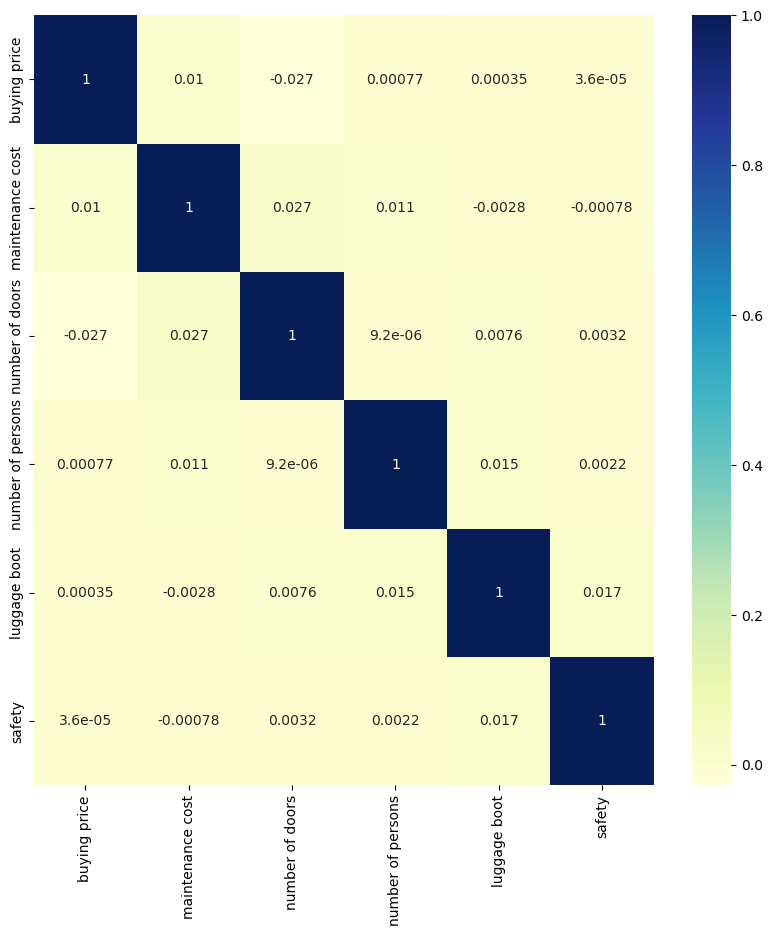

In [22]:
# Displaying heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(X.corr(method="pearson"), cmap="YlGnBu", annot=True)

In [ ]:
# # Drop correlated features
# df_train = df_train.drop(['country'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train.columns

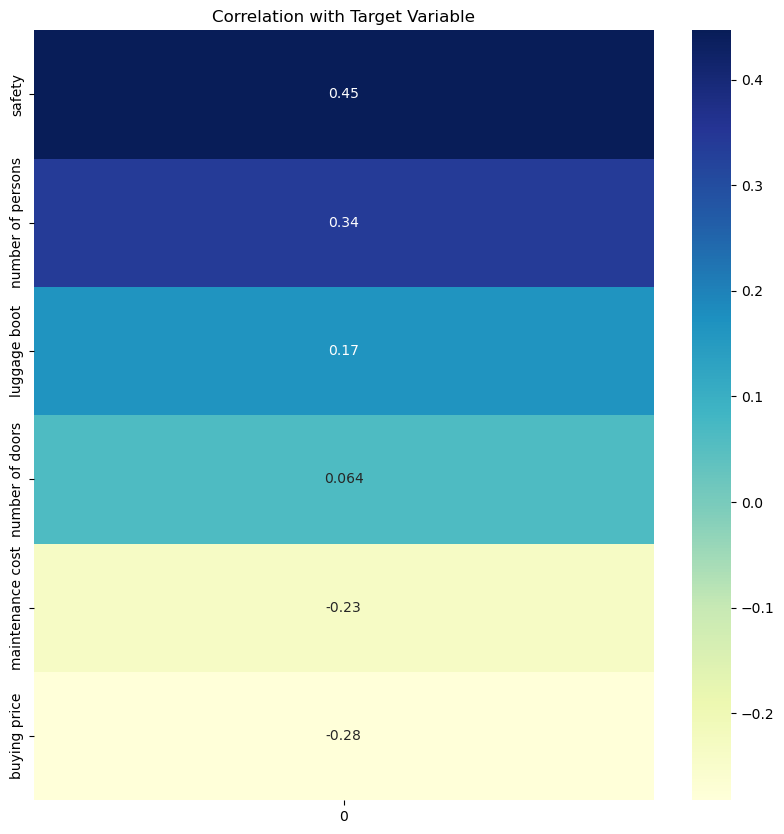

In [23]:
# Create a correlation matrix with target variable
corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_with_target.to_frame(), cmap='YlGnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

In [ ]:
# # Drop unimportant features
# df_train = df_train.drop(['country'], axis=1)
# df_train = df_train.reset_index(drop=True)
# df_train.columns

In [ ]:
# Show each unique values on categorical columns
print(f"Number of rows: {R}\n")

for col in categorical_cols:
    
    print(df_train[col].value_counts())

Number of rows: 1727

safety
0    464
2    460
1    458
Name: count, dtype: int64
number of persons
1    466
2    459
0    457
Name: count, dtype: int64
maintenance cost
3    351
0    348
1    344
2    339
Name: count, dtype: int64
luggage boot
1    467
2    460
0    455
Name: count, dtype: int64
buying price
3    354
0    349
2    348
1    331
Name: count, dtype: int64
number of doors
2    353
0    346
1    345
3    338
Name: count, dtype: int64
decision
0    966
1    311
2     54
3     51
Name: count, dtype: int64


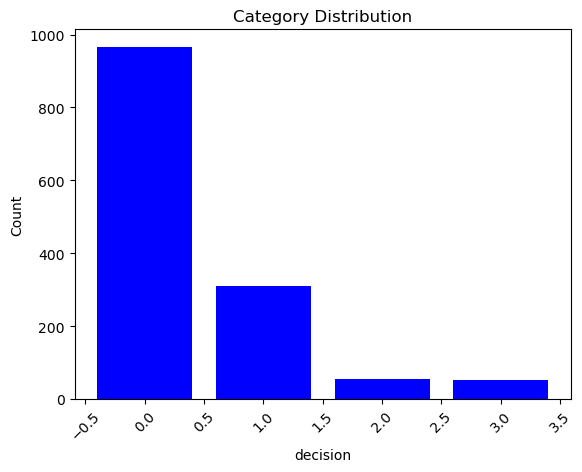

In [ ]:
## Distribution of target variable
# category_counts = df_train['Petrol consumption'].value_counts()

# # Plot the count plot
# plt.bar(category_counts.index, category_counts.values, color='blue')
# plt.xlabel('Petrol consumption')
# plt.ylabel('Count')
# plt.title('Category Distribution')
# plt.xticks(rotation=45)  # Rotate labels for better readability if needed
# plt.show()

**Important**: We detect outliers BEFORE creating polynomial features because:
1. Polynomial features amplify outliers exponentially (outlier² creates extreme values)
2. One outlier affects multiple polynomial features simultaneously  
3. This prevents model instability in polynomial regression

Do it when the data is sufficient

In [ ]:
# Show all numerical columns
numerical_columns = list(df_train.select_dtypes(include=[np.number]).columns.values)
numerical_columns

['buying price',
 'maintenance cost',
 'number of doors',
 'number of persons',
 'luggage boot',
 'safety',
 'decision']

In [ ]:
# Detect outliers
def detect_outliers_iqr(df, column):    
    """
    Detect outliers using IQR method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

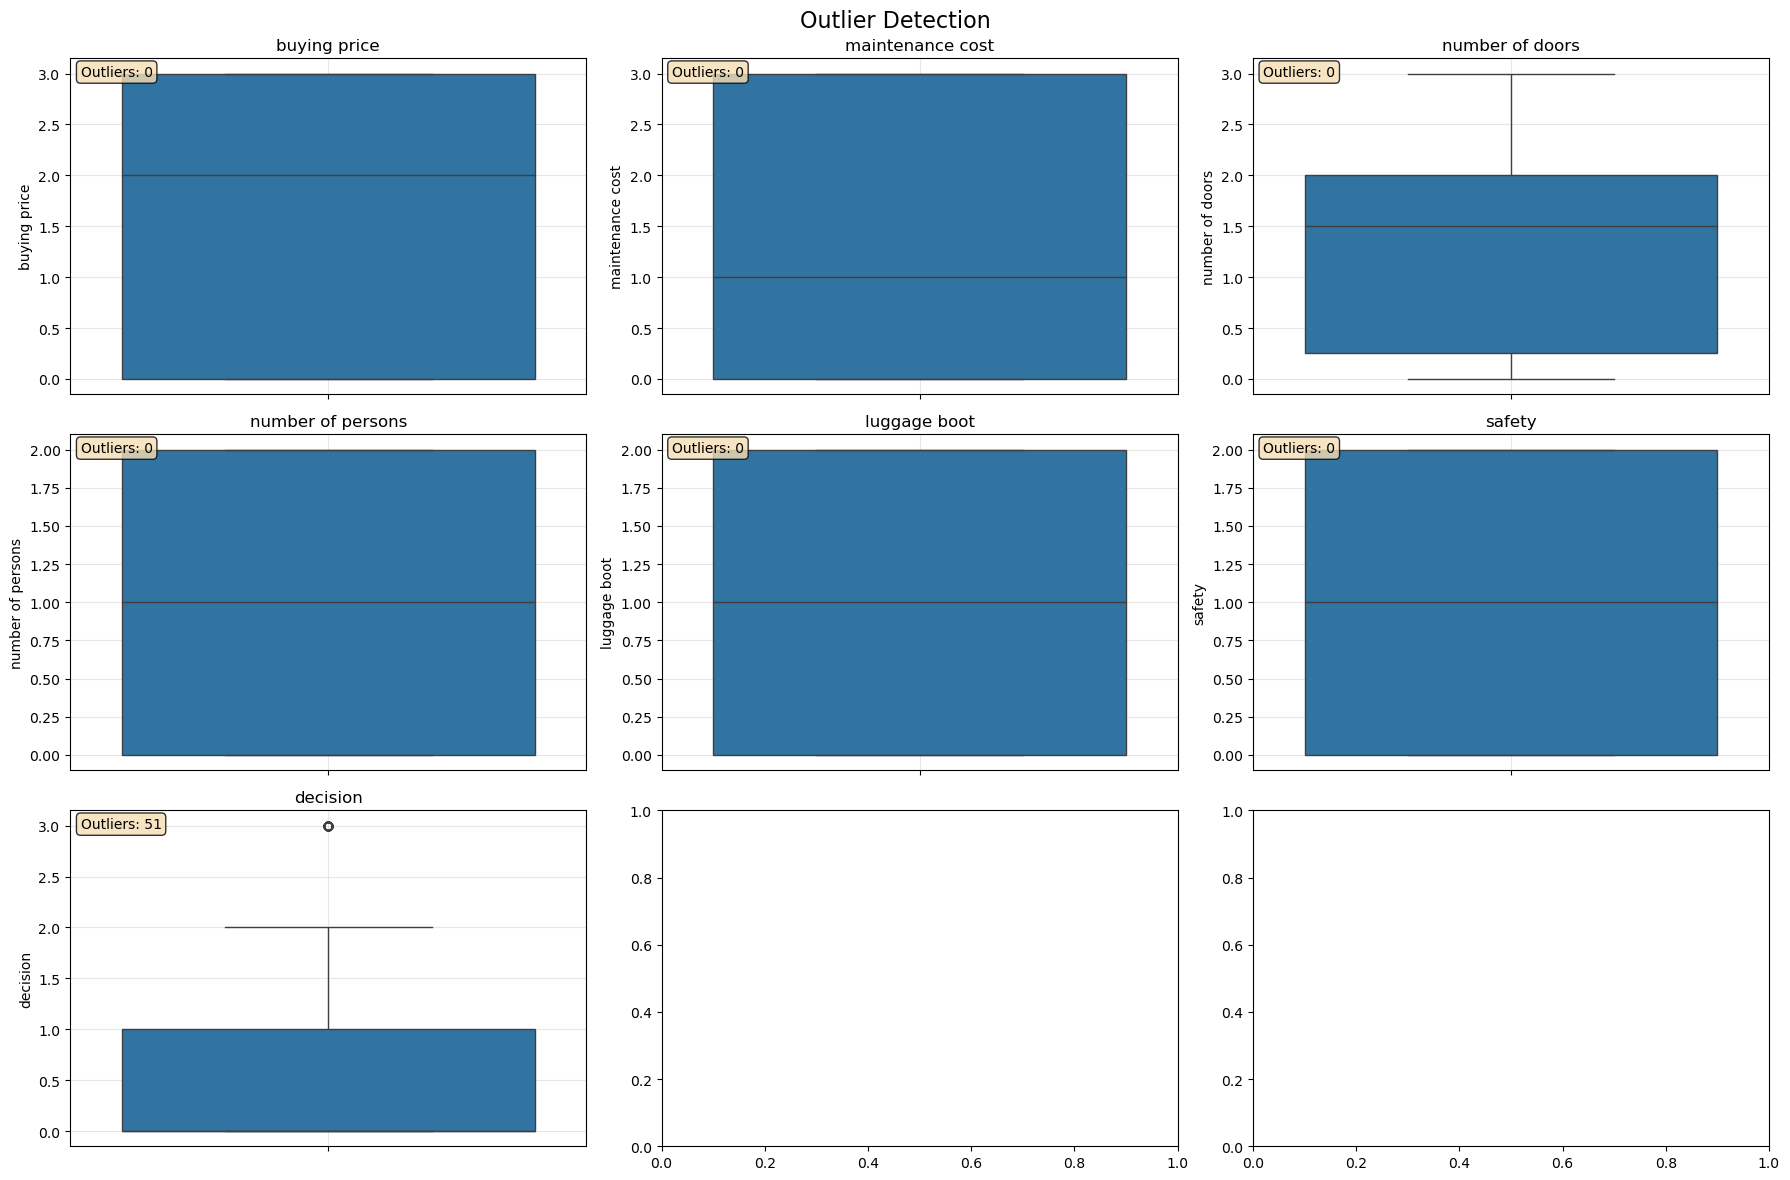

In [30]:
# Create box plots for all numerical features to visualize outliers
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Outlier Detection', fontsize=16)

lower_bounds = dict()
upper_bounds = dict()

for i, col in enumerate(numerical_columns):
    row = i // 3
    col_idx = i % 3
    
    # Create box plot
    sns.boxplot(data=df_train, y=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col}')
    axes[row, col_idx].grid(True, alpha=0.3)
    
    # Add outlier count as text
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df_train, col)
    lower_bounds[col] = lower_bound
    upper_bounds[col] = upper_bound
    
    axes[row, col_idx].text(0.02, 0.98, f'Outliers: {len(outliers)}', 
                           transform=axes[row, col_idx].transAxes,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
# # Remove outliers based on IQR method (only if the dataset is big enough)
# for i, col in enumerate(numerical_columns):
    
#     df_train = df_train[df_train[col] >= lower_bounds[col]]
#     df_train = df_train.reset_index(drop=True)
#     df_train = df_train[df_train[col] <= upper_bounds[col]]
#     df_train = df_train.reset_index(drop=True)

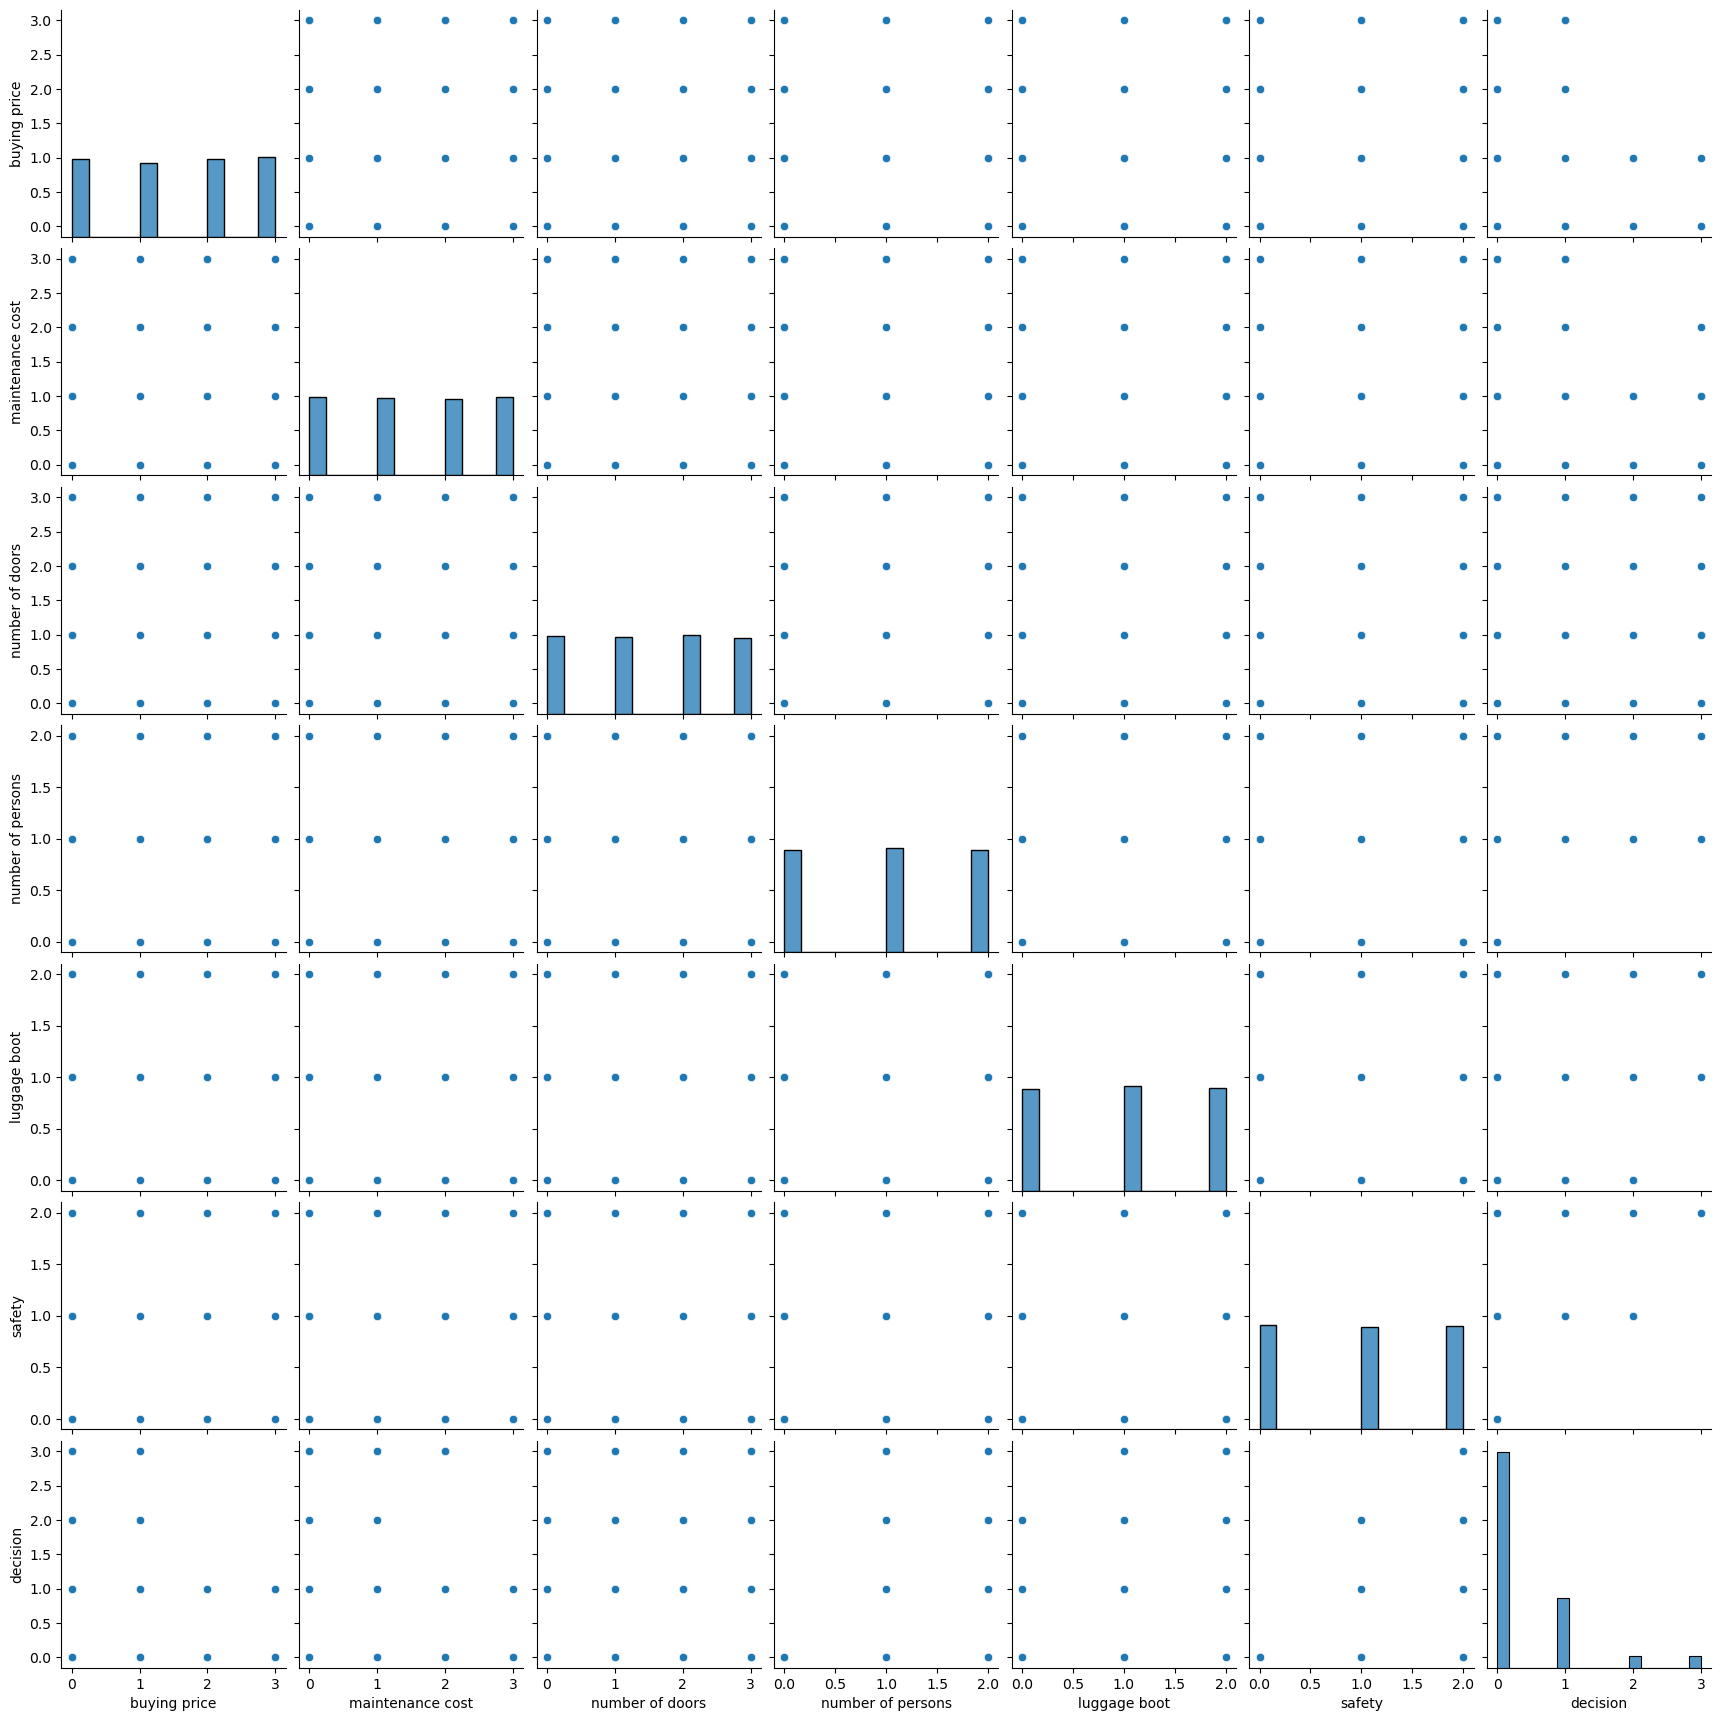

In [ ]:
# Show the distribution of all columns
sns.pairplot(df_train)

In [ ]:
# Show statistical information of the dataset
df_train.describe()

,buying price,maintenance cost,number of doors,number of persons,luggage boot,safety,decision
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,1.511577,1.501447,1.494211,1.001447,1.003618,0.997106,0.413893
std,1.126122,1.123605,1.113882,0.814423,0.813972,0.817968,0.736576
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.500000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000


In [33]:
# Separate features and labels
y_train = df_train['decision']
X_train = df_train.drop(['decision'], axis=1)

In [ ]:
# # MinMax Scaling
# numeric_cols = X_train.select_dtypes(include='number').columns

# scaler_X = MinMaxScaler()
# scaler_Y = MinMaxScaler()

# X_train[numeric_cols] = scaler_X.fit_transform(X_train[numeric_cols])
# y_train = scaler_Y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
# pd.DataFrame(y_train, columns=['Density'])

### 3.2 Testing Data

In [34]:
# Size of Dataset
print(f"Number of rows: {df_test.shape[0]}")
print(f"Number of columns: {df_test.shape[1]}")

Number of rows: 345
Number of columns: 7


In [ ]:
# # Drop unnecessary columns
# df_test = df_test.drop(['country'], axis=1)
# df_test = df_test.reset_index(drop=True)
# df_test = df_test.drop(['rank'], axis=1)
# df_test = df_test.reset_index(drop=True)
# df_test.columns

In [36]:
# Rename columns
headers = ["buying price", "maintenance cost", "number of doors",
           "number of persons", "luggage boot", "safety", "decision"]
df_test.columns = headers
df_test.columns

Index(['buying price', 'maintenance cost', 'number of doors',
       'number of persons', 'luggage boot', 'safety', 'decision'],
      dtype='object')

In [37]:
# Remove duplicated columns
# This will retain the first occurrences, change as you want
dup_cols = df_test.columns.duplicated()
cols = list(df_test.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

df_test = df_test.loc[:,~df_test.columns.duplicated()].copy()

print("After removing...")

dup_cols = df_test.columns.duplicated()
cols = list(df_test.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

Duplicated Columns: 
[]
After removing...
Duplicated Columns: 
[]


In [38]:
# Check for missing values
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   buying price       345 non-null    object
 1   maintenance cost   345 non-null    object
 2   number of doors    345 non-null    object
 3   number of persons  345 non-null    object
 4   luggage boot       345 non-null    object
 5   safety             345 non-null    object
 6   decision           345 non-null    object
dtypes: object(7)
memory usage: 19.0+ KB


In [39]:
# Remove row with missing values
df_test = df_test.dropna()
df_test = df_test.reset_index(drop=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   buying price       345 non-null    object
 1   maintenance cost   345 non-null    object
 2   number of doors    345 non-null    object
 3   number of persons  345 non-null    object
 4   luggage boot       345 non-null    object
 5   safety             345 non-null    object
 6   decision           345 non-null    object
dtypes: object(7)
memory usage: 19.0+ KB


In [42]:
# Show categorical columns
categorical_cols = list(set(df_test.columns.to_list()) - set(df_test._get_numeric_data().columns.to_list()))

print("Categorical columns:")
print(sorted(categorical_cols))

Categorical columns:
['buying price', 'decision', 'luggage boot', 'maintenance cost', 'number of doors', 'number of persons', 'safety']


In [43]:
# Show unique values in categorical columns
unique_values = []

for col in categorical_cols:
    unique_value = [col]
    unique_value.append(", ".join(df_test[col].unique()))
    unique_values.append(unique_value)

pd.DataFrame(unique_values, columns=["col", "unique values"])

,col,unique values
0,safety,"medium, low, high"
1,number of persons,"2, 4, more"
2,maintenance cost,"low, high, medium, very high"
3,luggage boot,"medium, big, small"
4,buying price,"high, low, medium, very high"
5,number of doors,"2, 3, more, 4"
6,decision,"unaccepted, accepted, good, very good"


In [44]:
# Encode categorical columns using OrdinalEncoder

enc_maps = {
    "buying price" : [{'col': "buying price", 'mapping': {"low": 0, "medium": 1, "high": 2, "very high": 3}}],
    "maintenance cost" : [{'col': "maintenance cost", 'mapping': {"low": 0, "medium": 1, "high": 2, "very high": 3}}],
    "number of doors" : [{'col': "number of doors", 'mapping': {"2": 0, "3": 1, "4": 2, "more": 3}}],
    "number of persons" : [{'col': "number of persons", 'mapping': {"2": 0, "4": 1, "more": 2}}],
    "luggage boot" : [{'col': "luggage boot", 'mapping': {"small": 0, "medium": 1, "big": 2}}],
    "safety" : [{'col': "safety", 'mapping': {"low": 0, "medium": 1, "high": 2}}],
    "decision" : [{'col': "decision", 'mapping': {"unaccepted": 0, "accepted": 1, "good": 2, "very good": 3}}]
}

for col in categorical_cols:
    enc_map = enc_maps[col]

    enc = OrdinalEncoder(mapping=enc_map)
    df_test = enc.fit_transform(df_test)


df_test

,buying price,maintenance cost,number of doors,number of persons,luggage boot,safety,decision
0,2,0,0,0,1,1,0
1,0,2,0,0,1,0,0
2,2,2,1,1,2,0,0
3,2,1,0,2,2,1,1
4,1,2,3,0,1,1,0
...,...,...,...,...,...,...,...
340,0,1,1,1,2,0,0
341,1,3,1,2,1,2,1
342,3,2,2,0,1,1,0
343,1,0,3,2,0,2,2


In [ ]:
# # Drop correlated features
# df_test = df_test.drop(['country'], axis=1)
# df_test = df_test.reset_index(drop=True)
# df_test.columns

In [ ]:
# # Drop unimportant features
# df_test = df_test.drop(['country'], axis=1)
# df_test = df_test.reset_index(drop=True)
# df_test.columns

In [45]:
# Separate features and labels
y_test = df_test['decision']
X_test = df_test.drop(['decision'], axis=1)

In [ ]:
# # MinMax Scaling
# numeric_cols = X_test.select_dtypes(include='number').columns

# scaler_X = MinMaxScaler()
# scaler_Y = MinMaxScaler()

# X_test[numeric_cols] = scaler_X.fit_transform(X_test[numeric_cols])
# y_test = scaler_Y.fit_transform(y_test.values.reshape(-1, 1)).flatten()
# pd.DataFrame(y_test, columns=['Density'])

# 4. Decision Tree

In [47]:
model = DecisionTreeClassifier(criterion="entropy")
model.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [49]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

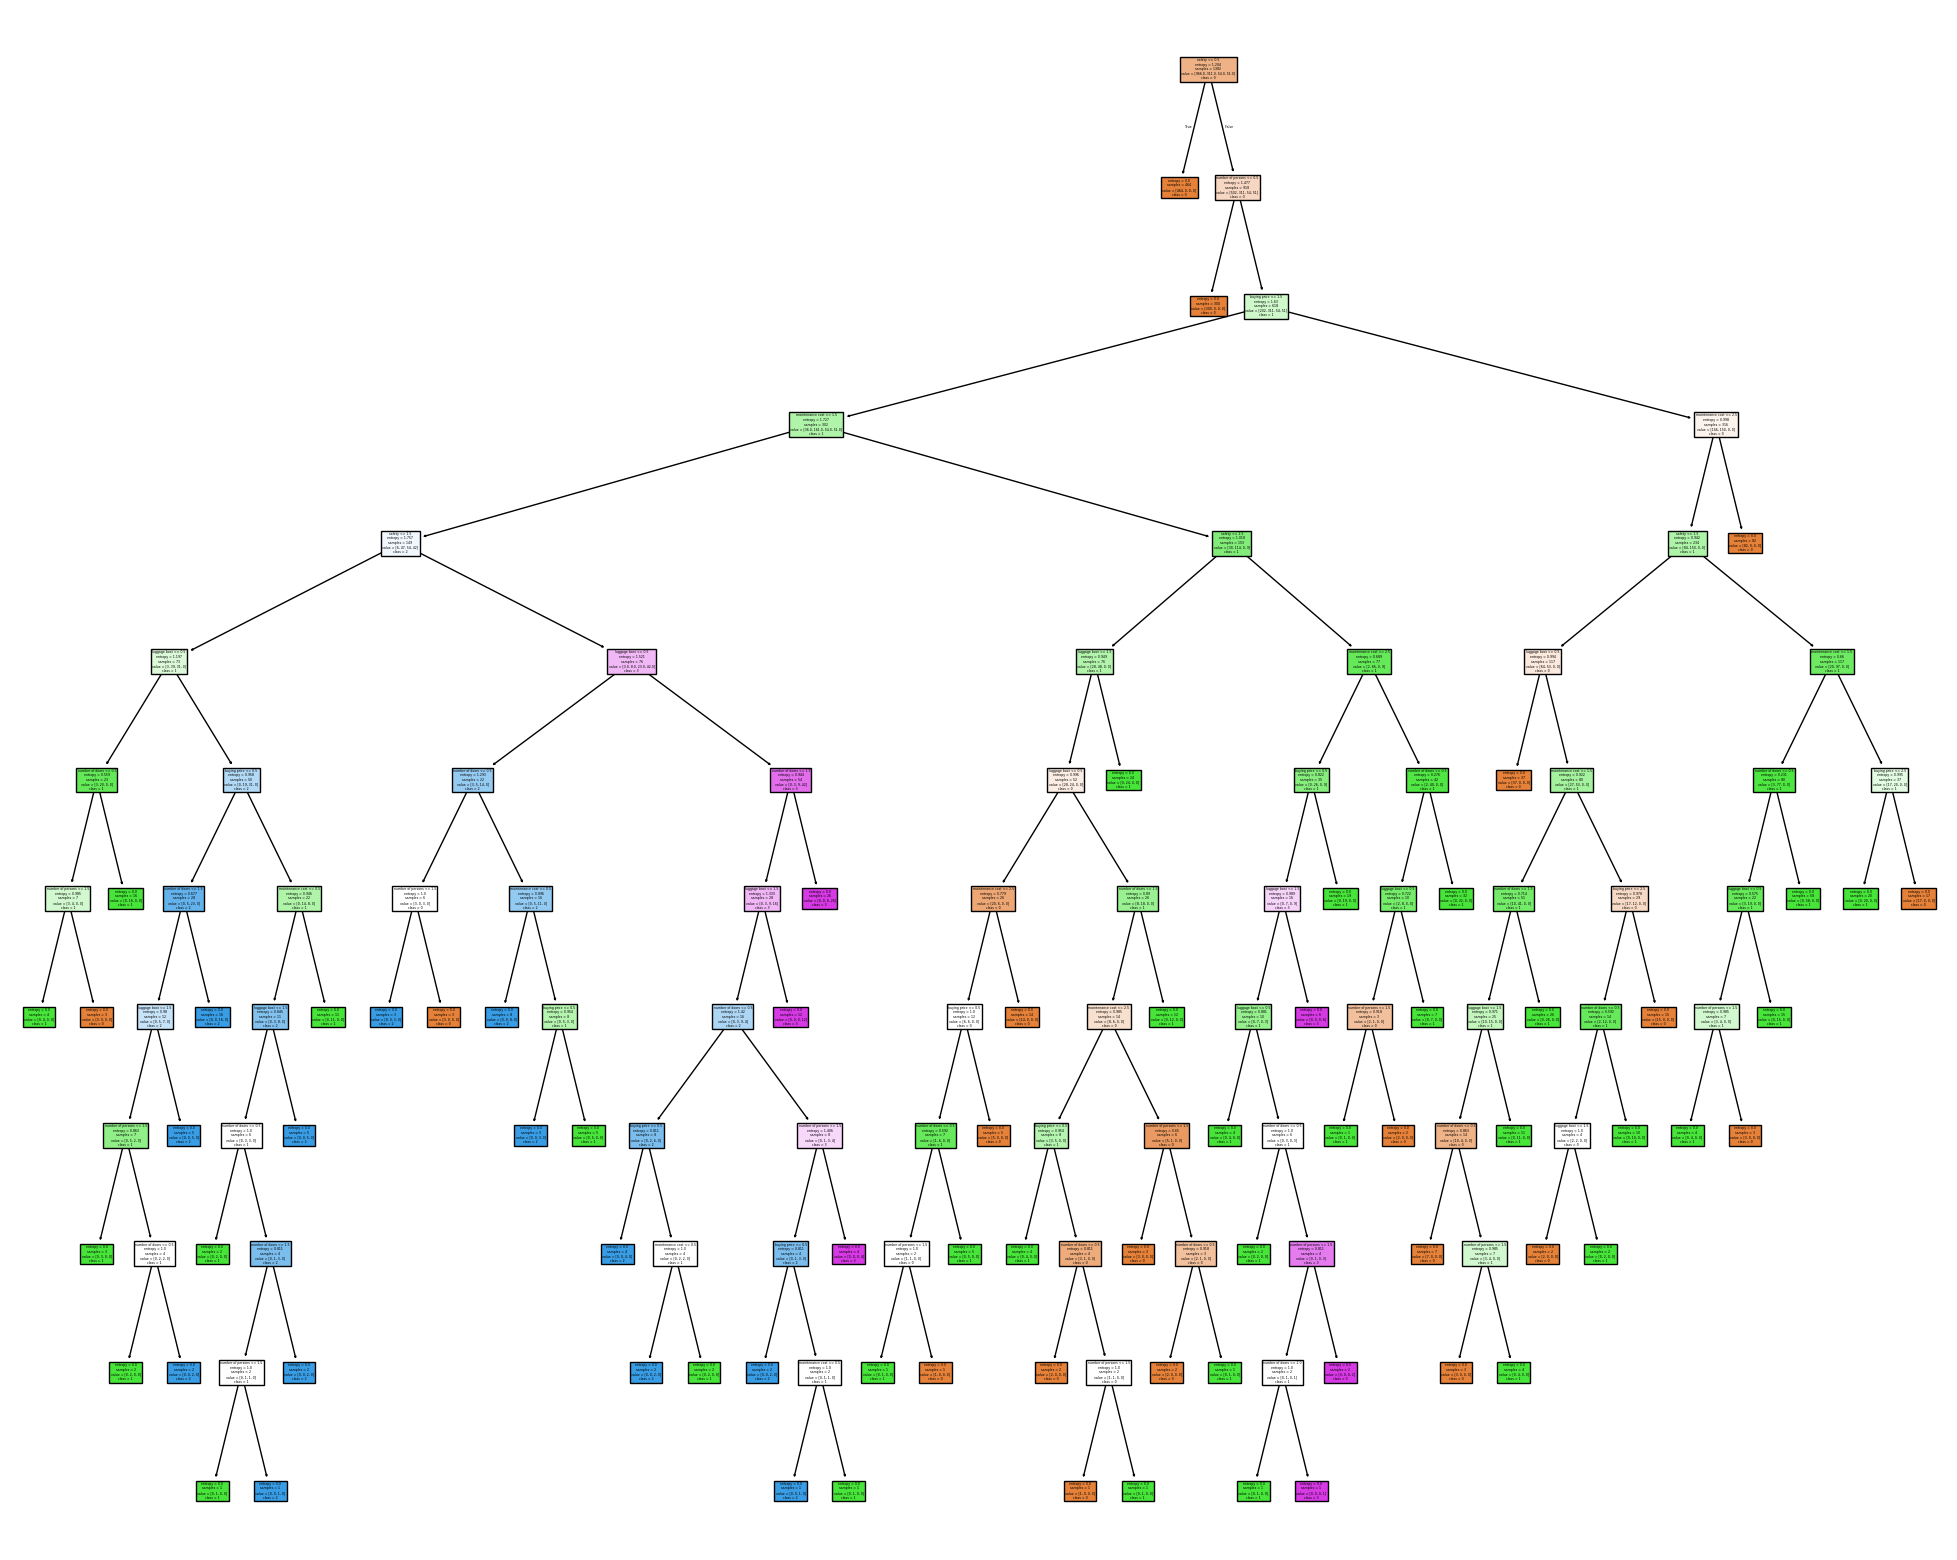

In [66]:
plt.figure(figsize=(25,20))
plot_tree(model,
                       feature_names=X.columns,
                       class_names=['0', "1", "2", "3"],
                       filled=True)
plt.show()

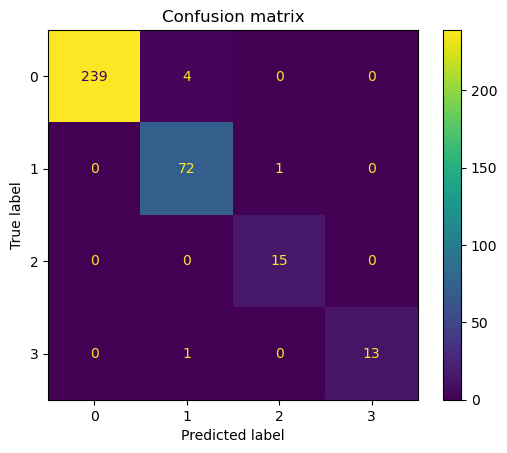

Training acc score: 1.0
Testing acc score: 0.9826086956521739

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       239
           1       0.99      0.94      0.96        77
           2       1.00      0.94      0.97        16
           3       0.93      1.00      0.96        13

    accuracy                           0.98       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.98      0.98      0.98       345



In [57]:
# Model evaluation

# Function to plot the multilabel confusion matrix
def plot_multilabel_confusion_matrix(confusion_mtx, class_names):
    num_classes = confusion_mtx.shape[0]
    ncols = 2  # Set the number of columns for the plot
    nrows = (num_classes + ncols - 1) // ncols  # Calculate the number of rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for i in range(num_classes):
        ax = axes[i]
        ax.matshow(confusion_mtx[i], cmap=plt.cm.Blues, alpha=0.5)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(class_names[i])

        # Show the counts
        for j in range(confusion_mtx[i].shape[0]):
            for k in range(confusion_mtx[i].shape[1]):
                ax.text(k, j, confusion_mtx[i][j, k], ha='center', va='center')

    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Fungsi untuk mengevaluasi dan mengembalikan hasil sebagai kamus
def evaluate_model(model, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    cm = multilabel_confusion_matrix(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(len(y.unique()))])
    disp.plot()
    plt.title("Confusion matrix")
    plt.show()
    print("Training acc score:", accuracy_score(y_train, y_train_pred))
    print("Testing acc score:", accuracy_score(y_test, y_pred))
    print()
    print(classification_report(y_pred,y_test))

evaluate_model(model, X_test, y_test)

# 5. Tuning

In [60]:
base_model = DecisionTreeClassifier()

params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=base_model, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [61]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: total: 188 ms
Wall time: 4.17 s


,estimator,DecisionTreeClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, ...], 'min_samples_leaf': [5, 10, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [62]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006379,0.004903,0.003565,0.001616,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.783237,0.777457,0.776812,0.773913,0.777855,0.003382,41
1,0.003672,0.000983,0.003207,0.000589,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.783237,0.777457,0.776812,0.773913,0.777855,0.003382,41
2,0.004296,0.001590,0.002130,0.000545,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.783237,0.777457,0.776812,0.773913,0.777855,0.003382,41
3,0.002467,0.000617,0.001593,0.000562,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.783237,0.777457,0.776812,0.773913,0.777855,0.003382,41
4,0.003265,0.000445,0.002009,0.000359,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.783237,0.777457,0.776812,0.773913,0.777855,0.003382,41


In [65]:
best_params = grid_search.best_estimator_
best_params

,criterion,'entropy'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


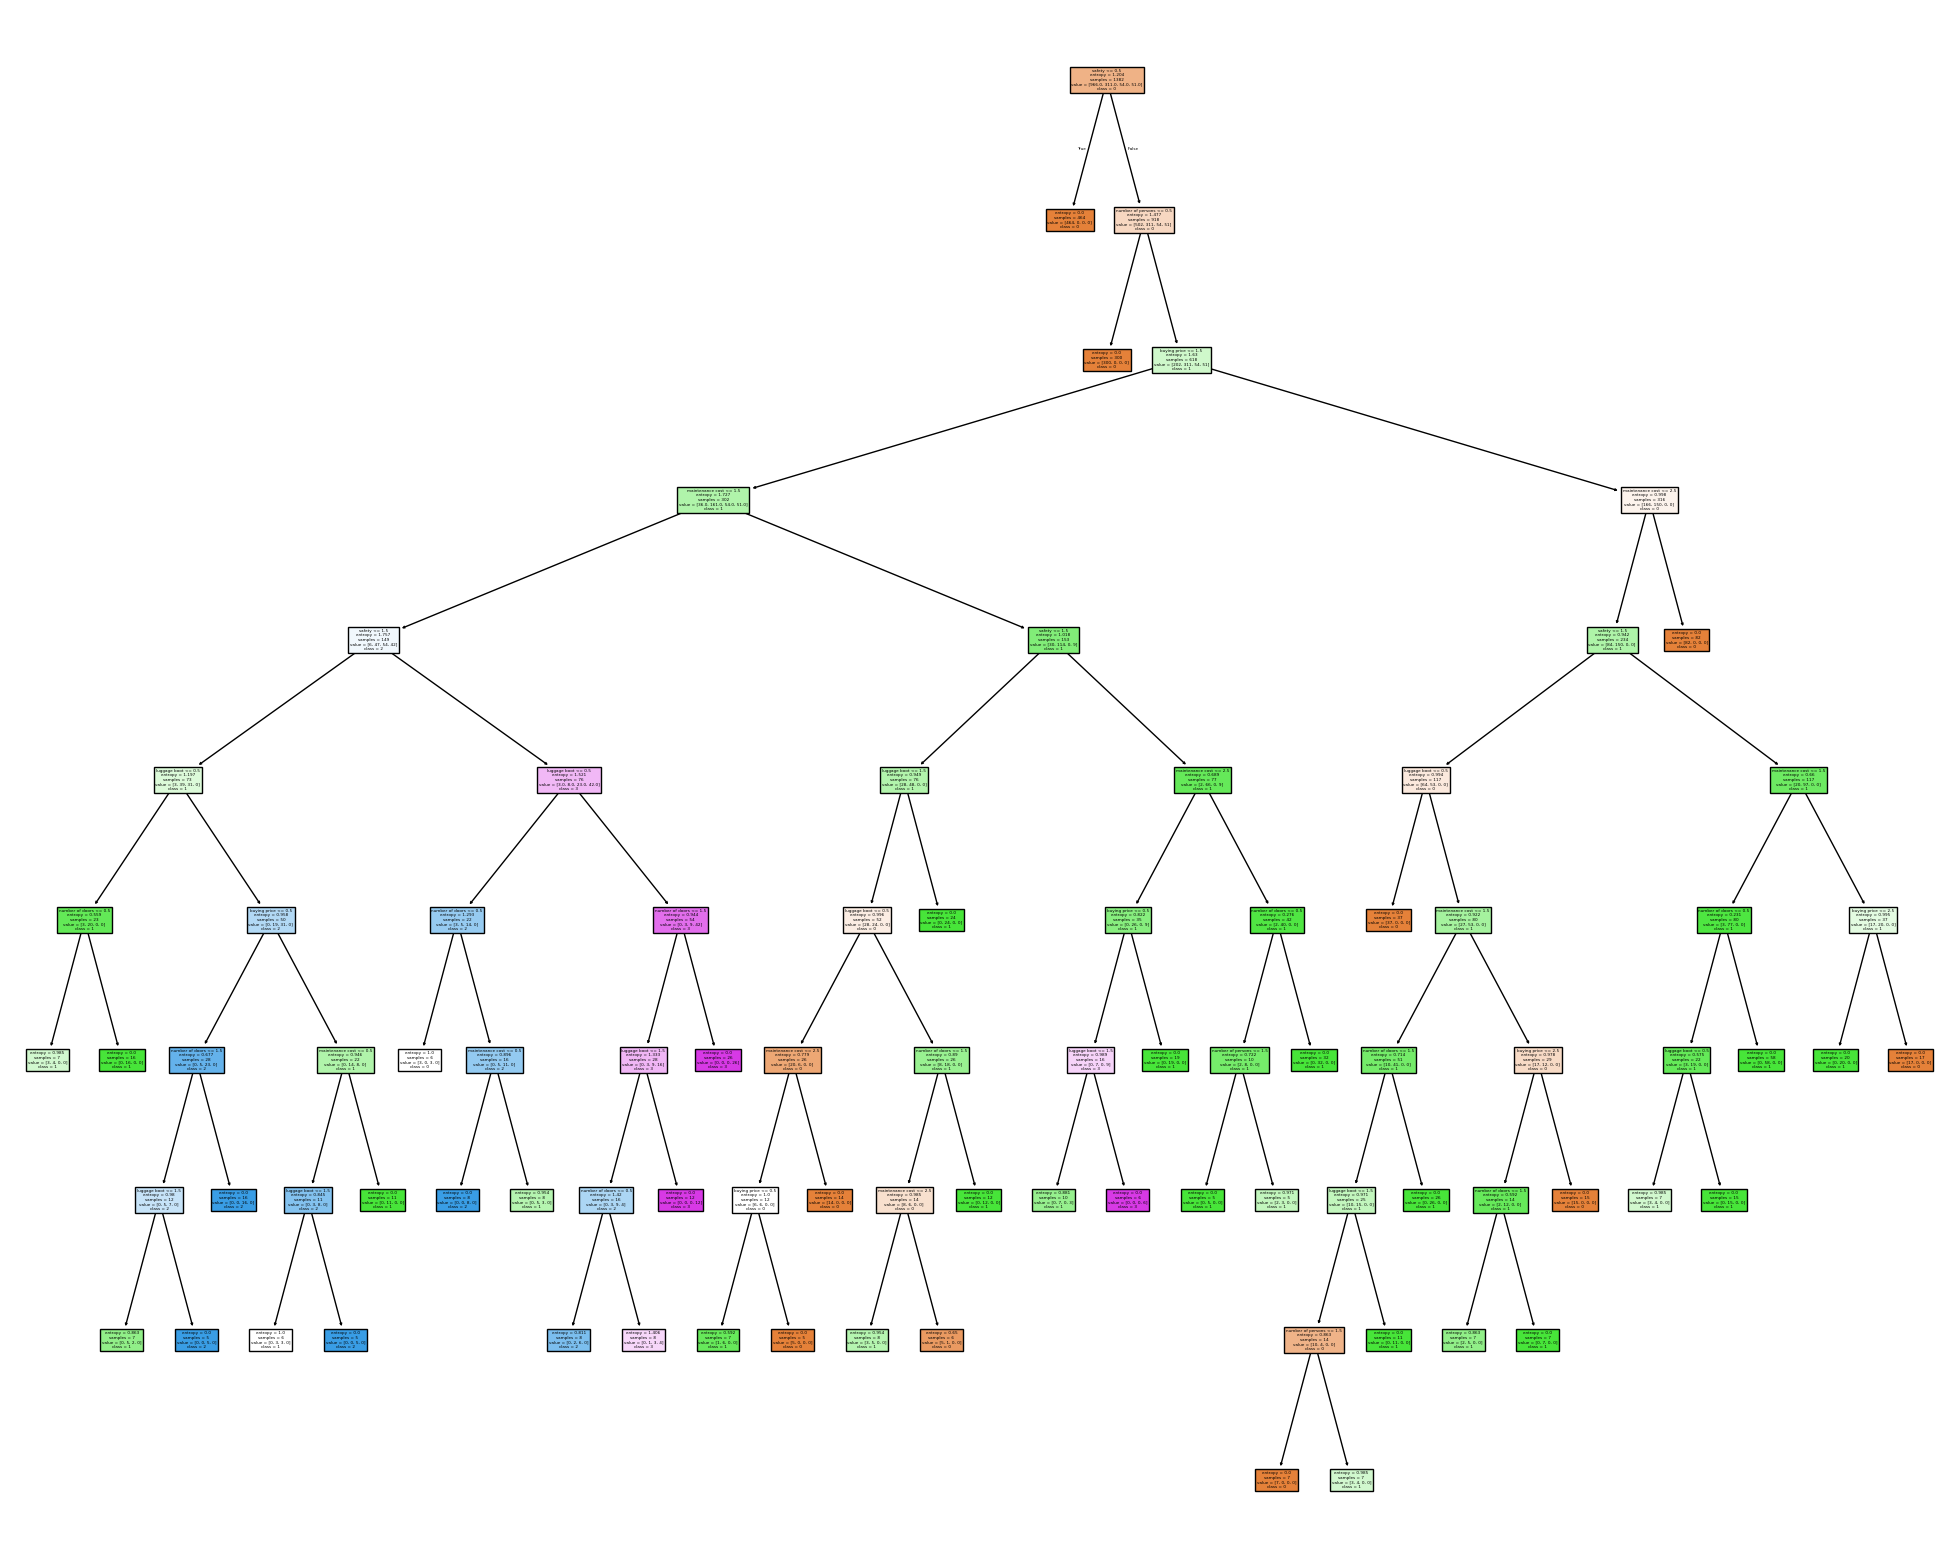

In [67]:
plt.figure(figsize=(25,20))
plot_tree(best_params,
                       feature_names=X.columns,
                       class_names=['0', "1", "2", "3"],
                       filled=True)
plt.show()

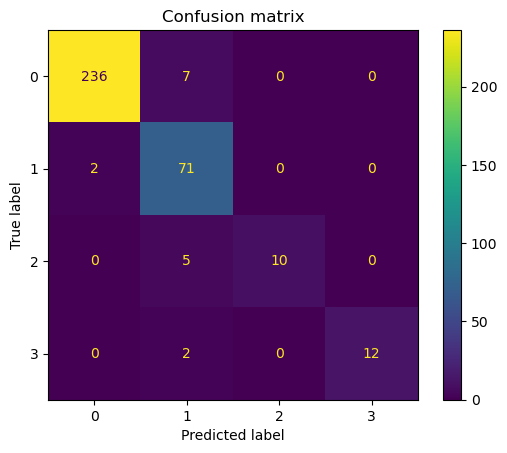

Training acc score: 0.9725036179450073
Testing acc score: 0.9536231884057971

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       238
           1       0.97      0.84      0.90        85
           2       0.67      1.00      0.80        10
           3       0.86      1.00      0.92        12

    accuracy                           0.95       345
   macro avg       0.87      0.96      0.90       345
weighted avg       0.96      0.95      0.95       345



In [64]:
# Evaluate the best model
evaluate_model(best_params, X_test, y_test)